In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pathlib 
import sys
from tqdm import tqdm

sys.path.append("..")
from lib.utils import show_mask_image

from  lib.sample_patches_main import sample_patches, sample_hard_negatives, sample_blob_negatives


In [2]:
annotations = pd.read_json('../resources/ddsm/ddsm_annotations.json', orient='records', lines=True)
print(len(annotations)) # coincide con el número de máscaras
split_csv = '../resources/ddsm/DDSM_test.csv'
print("Num images in test split: ", len(pd.read_csv(split_csv)))
test_images = pd.read_csv(split_csv)
print("num test images: ", len(test_images))

#test_images = test_images.ddsm_image.values


4664
Num images in test split:  612
num test images:  612


In this sample the boundary is beyond the image limits

max points:  [903.23674912 544.16559718]


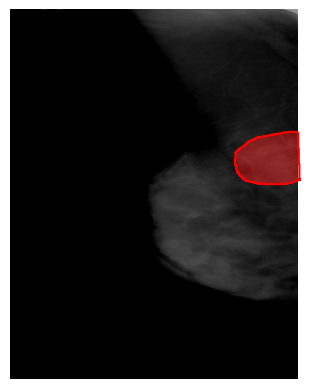

In [5]:
annotation = annotations.iloc[2]
ddsm_root_dir = pathlib.Path('/home/alalbiol/Data/mamo/DDSM_png_1152x896')

image_id = annotation['image_id']
image_path = ddsm_root_dir / image_id
img = np.array(Image.open(str(image_path)))

mask_id = annotation['mask_id']
roi_mask_path = ddsm_root_dir / mask_id
roi_mask = np.array(Image.open(str(roi_mask_path)))

points = np.array(annotation['outline']).T

show_mask_image(img, roi_mask)
plt.plot(points[:,0], points[:,1], 'r-')

print("max points: ", np.max(points, axis=0))
# hay anotaciones que se salen de la imagen hay que tener cuidado con eso




In [ ]:
    


def extract_patches_from_anot(annotation, test_images, out_dir,  ddsm_root_dir, nb_abn = 2, nb_bkg = 1, 
                            patch_size=512, verbose=False):
    ddsm_root_dir = pathlib.Path(ddsm_root_dir)
    
    image_id = annotation['image_id']
    

    if image_id not in test_images:
        return
    
    
    image_path = ddsm_root_dir / image_id
    img = np.array(Image.open(str(image_path)))
    
    mask_id = annotation['mask_id']
    roi_mask_path = ddsm_root_dir / mask_id
    roi_mask = np.array(Image.open(str(roi_mask_path)))
    
    points = np.array(annotation['outline']).T
    
    xmin, ymin = points.min(axis=0)
    xmax, ymax = points.max(axis=0)
    xmin = max(xmin, 0)
    ymin = max(ymin, 0)
    xmax = min(xmax, img.shape[1]-1)
    ymax = min(ymax, img.shape[0]-1)
    
    width = xmax - xmin
    height = ymax - ymin
    bounding_box = (xmin, ymin, width, height)
    
    assert xmin >= 0 
    assert ymin >= 0 
    assert xmax < img.shape[1], f"{xmax} < {img.shape[1]}"
    assert ymax < img.shape[0]
    

    
    sample_patches(img, roi_mask, out_dir, mask_id, bounding_box, patch_size=patch_size,
                pos_cutoff=.9, neg_cutoff=.1,
                nb_bkg=nb_bkg, nb_abn=nb_abn,
                verbose=verbose)
    



Extract patches from one annotation

D_4161_1.RIGHT_MLO_CALCIFICATION_MALIGNANT_mask_0_0000_mask.png: sampled abn at (813, 381)
D_4161_1.RIGHT_MLO_CALCIFICATION_MALIGNANT_mask_0_0001_mask.png: sampled abn at (868, 436)
D_4161_1.RIGHT_MLO_CALCIFICATION_MALIGNANT_mask_0_0002_mask.png: sampled abn at (761, 441)
D_4161_1.RIGHT_MLO_CALCIFICATION_MALIGNANT_mask_0_0003_mask.png: sampled abn at (750, 503)
D_4161_1.RIGHT_MLO_CALCIFICATION_MALIGNANT_mask_0_0004_mask.png: sampled abn at (882, 433)
D_4161_1.RIGHT_MLO_CALCIFICATION_MALIGNANT_mask_0_0005_mask.png: sampled abn at (757, 529)
D_4161_1.RIGHT_MLO_CALCIFICATION_MALIGNANT_mask_0_0006_mask.png: sampled abn at (829, 521)
D_4161_1.RIGHT_MLO_CALCIFICATION_MALIGNANT_mask_0_0007_mask.png: sampled abn at (856, 483)
D_4161_1.RIGHT_MLO_CALCIFICATION_MALIGNANT_mask_0_0000_mask.png: sampled a bkg at= (66, 779)
D_4161_1.RIGHT_MLO_CALCIFICATION_MALIGNANT_mask_0_0001_mask.png: sampled a bkg at= (134, 264)
D_4161_1.RIGHT_MLO_CALCIFICATION_MALIGNANT_mask_0_0002_mask.png: sampled a bkg at= (2

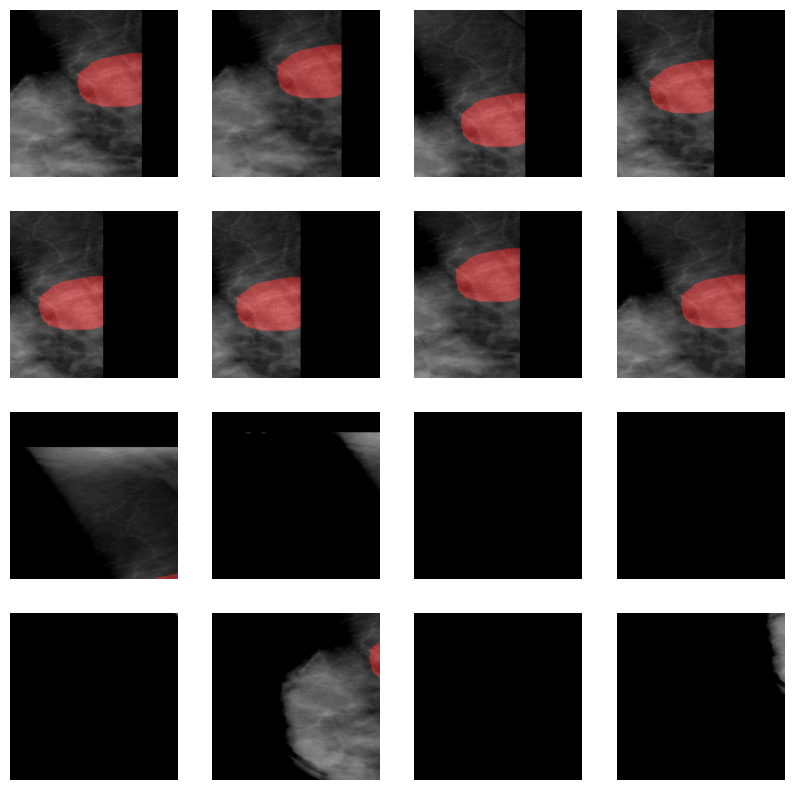

In [8]:


root_ddsm = '/home/alalbiol/Data/mamo/DDSM_png_1152x896'

patch_size = 512
out_dir = pathlib.Path(f'/tmp/ex_patches/')
out_dir.mkdir(exist_ok=True)

test_images =  annotations.image_id.unique() # all images here
nrow = 4
ncol = 4
num_images = nrow * ncol


extract_patches_from_anot(annotations.iloc[2], test_images, out_dir, root_ddsm, 
                            patch_size=patch_size,
                            nb_abn=8, nb_bkg=8,
                            verbose=True
                            )



images = list(out_dir.rglob('*img.png'))

print ("Num images: ", len(images))
#sample 16 images

#images = np.random.choice(images, num_images)
masks = [str(img).replace('_img.png', '_mask.png') for img in images]
print("Num images: ", len(images), len(masks))

fig, ax = plt.subplots(nrows=nrow, ncols=ncol, figsize=(10, 10))
ax = ax.ravel()




for i in range(num_images):
    img = np.array(Image.open(images[i]))
    assert img.shape[0] == img.shape[1] and img.shape[0] == patch_size, f"{img.shape}"
    mask = np.array(Image.open(masks[i]))
    show_mask_image(img, mask, ax[i])


Not extract patches from all the dataset with several sizes

In [9]:
# let's clean the directory
!rm /tmp/eval_patches_* -rf 

In [10]:

test_images = pd.read_csv(split_csv)
test_images = test_images.ddsm_image.values
print("num test images: ", len(test_images))

root_ddsm = '/home/alalbiol/Data/mamo/DDSM_png_1152x896'

for patch_size in [ 512, 256, 224]:
    print(f"Extractig patches of size {patch_size}")
    out_dir = pathlib.Path(f'/tmp/eval_patches_{patch_size}/')
    out_dir.mkdir(exist_ok=True)

    for k in tqdm(range(len(annotations))):
        extract_patches_from_anot(annotations.iloc[k], test_images, out_dir, root_ddsm, 
                                patch_size=patch_size)
    

 

num test images:  612
Extractig patches of size 512


100%|██████████| 4664/4664 [01:21<00:00, 57.50it/s] 


Extractig patches of size 256


  1%|          | 52/4664 [00:00<00:53, 85.97it/s]

Nb of trials reached maximum, decrease overlap cutoff by 0.05
Nb of trials reached maximum, decrease overlap cutoff by 0.05


  2%|▏         | 94/4664 [00:10<09:49,  7.75it/s]

Nb of trials reached maximum, decrease overlap cutoff by 0.05
Nb of trials reached maximum, decrease overlap cutoff by 0.05
Nb of trials reached maximum, decrease overlap cutoff by 0.05


  5%|▌         | 247/4664 [00:27<03:44, 19.71it/s]

Nb of trials reached maximum, decrease overlap cutoff by 0.05


  6%|▌         | 265/4664 [00:32<10:08,  7.23it/s]

Nb of trials reached maximum, decrease overlap cutoff by 0.05


  6%|▌         | 284/4664 [00:38<13:26,  5.43it/s]

Nb of trials reached maximum, decrease overlap cutoff by 0.05


  7%|▋         | 308/4664 [00:45<17:18,  4.20it/s]

Nb of trials reached maximum, decrease overlap cutoff by 0.05


  7%|▋         | 347/4664 [00:50<10:43,  6.71it/s]

Nb of trials reached maximum, decrease overlap cutoff by 0.05


  8%|▊         | 373/4664 [00:55<11:59,  5.96it/s]

Nb of trials reached maximum, decrease overlap cutoff by 0.05


  9%|▊         | 406/4664 [01:01<10:22,  6.84it/s]

Nb of trials reached maximum, decrease overlap cutoff by 0.05
Nb of trials reached maximum, decrease overlap cutoff by 0.05
Nb of trials reached maximum, decrease overlap cutoff by 0.05


  9%|▊         | 406/4664 [01:18<10:22,  6.84it/s]

Nb of trials reached maximum, decrease overlap cutoff by 0.05
Nb of trials reached maximum, decrease overlap cutoff by 0.05
Nb of trials reached maximum, decrease overlap cutoff by 0.05
Nb of trials reached maximum, decrease overlap cutoff by 0.05
Nb of trials reached maximum, decrease overlap cutoff by 0.05


 10%|█         | 477/4664 [01:40<12:58,  5.38it/s]  

Nb of trials reached maximum, decrease overlap cutoff by 0.05
Nb of trials reached maximum, decrease overlap cutoff by 0.05


 11%|█         | 514/4664 [01:50<15:31,  4.45it/s]

Nb of trials reached maximum, decrease overlap cutoff by 0.05
Nb of trials reached maximum, decrease overlap cutoff by 0.05
Nb of trials reached maximum, decrease overlap cutoff by 0.05


 11%|█         | 514/4664 [02:08<15:31,  4.45it/s]

Nb of trials reached maximum, decrease overlap cutoff by 0.05
Nb of trials reached maximum, decrease overlap cutoff by 0.05


 11%|█         | 522/4664 [02:14<40:13,  1.72it/s]

Nb of trials reached maximum, decrease overlap cutoff by 0.05


 13%|█▎        | 607/4664 [02:20<06:24, 10.56it/s]

Nb of trials reached maximum, decrease overlap cutoff by 0.05


 13%|█▎        | 623/4664 [02:24<10:11,  6.61it/s]

Nb of trials reached maximum, decrease overlap cutoff by 0.05


 34%|███▍      | 1582/4664 [02:40<00:22, 134.90it/s]

Nb of trials reached maximum, decrease overlap cutoff by 0.05


 35%|███▌      | 1653/4664 [02:45<01:31, 32.92it/s] 

Nb of trials reached maximum, decrease overlap cutoff by 0.05


 50%|█████     | 2336/4664 [02:57<00:16, 142.95it/s]

Nb of trials reached maximum, decrease overlap cutoff by 0.05
Nb of trials reached maximum, decrease overlap cutoff by 0.05


 50%|█████     | 2336/4664 [03:08<00:16, 142.95it/s]

Nb of trials reached maximum, decrease overlap cutoff by 0.05
Nb of trials reached maximum, decrease overlap cutoff by 0.05
Nb of trials reached maximum, decrease overlap cutoff by 0.05
Nb of trials reached maximum, decrease overlap cutoff by 0.05


 69%|██████▊   | 3200/4664 [03:32<00:13, 106.39it/s]

Nb of trials reached maximum, decrease overlap cutoff by 0.05
Nb of trials reached maximum, decrease overlap cutoff by 0.05


 77%|███████▋  | 3606/4664 [03:46<00:18, 57.92it/s] 

Nb of trials reached maximum, decrease overlap cutoff by 0.05
Nb of trials reached maximum, decrease overlap cutoff by 0.05


 77%|███████▋  | 3606/4664 [03:58<00:18, 57.92it/s]

Nb of trials reached maximum, decrease overlap cutoff by 0.05


 78%|███████▊  | 3623/4664 [04:00<05:24,  3.21it/s]

Nb of trials reached maximum, decrease overlap cutoff by 0.05
Nb of trials reached maximum, decrease overlap cutoff by 0.05
Nb of trials reached maximum, decrease overlap cutoff by 0.05


100%|██████████| 4664/4664 [04:24<00:00, 17.65it/s] 


Extractig patches of size 224


  1%|          | 51/4664 [00:01<01:24, 54.64it/s]

Nb of trials reached maximum, decrease overlap cutoff by 0.05
Nb of trials reached maximum, decrease overlap cutoff by 0.05
Nb of trials reached maximum, decrease overlap cutoff by 0.05


  1%|          | 56/4664 [00:14<37:56,  2.02it/s]

Nb of trials reached maximum, decrease overlap cutoff by 0.05
Nb of trials reached maximum, decrease overlap cutoff by 0.05


  8%|▊         | 383/4664 [00:28<01:35, 44.87it/s]

Nb of trials reached maximum, decrease overlap cutoff by 0.05


  9%|▉         | 414/4664 [00:33<05:53, 12.02it/s]

Nb of trials reached maximum, decrease overlap cutoff by 0.05
Nb of trials reached maximum, decrease overlap cutoff by 0.05


  9%|▉         | 414/4664 [00:44<05:53, 12.02it/s]

Nb of trials reached maximum, decrease overlap cutoff by 0.05
Nb of trials reached maximum, decrease overlap cutoff by 0.05
Nb of trials reached maximum, decrease overlap cutoff by 0.05
Nb of trials reached maximum, decrease overlap cutoff by 0.05
Nb of trials reached maximum, decrease overlap cutoff by 0.05


 10%|▉         | 447/4664 [01:04<20:15,  3.47it/s]

Nb of trials reached maximum, decrease overlap cutoff by 0.05
Nb of trials reached maximum, decrease overlap cutoff by 0.05


 13%|█▎        | 595/4664 [01:15<02:16, 29.82it/s]

Nb of trials reached maximum, decrease overlap cutoff by 0.05
Nb of trials reached maximum, decrease overlap cutoff by 0.05
Nb of trials reached maximum, decrease overlap cutoff by 0.05


 13%|█▎        | 623/4664 [01:28<14:41,  4.59it/s]

Nb of trials reached maximum, decrease overlap cutoff by 0.05
Nb of trials reached maximum, decrease overlap cutoff by 0.05


 16%|█▌        | 735/4664 [01:39<03:47, 17.23it/s]

Nb of trials reached maximum, decrease overlap cutoff by 0.05
Nb of trials reached maximum, decrease overlap cutoff by 0.05
Nb of trials reached maximum, decrease overlap cutoff by 0.05


 16%|█▌        | 735/4664 [01:54<03:47, 17.23it/s]

Nb of trials reached maximum, decrease overlap cutoff by 0.05


 17%|█▋        | 789/4664 [01:57<08:16,  7.80it/s]

Nb of trials reached maximum, decrease overlap cutoff by 0.05


 20%|██        | 952/4664 [02:05<02:20, 26.49it/s]

Nb of trials reached maximum, decrease overlap cutoff by 0.05
Nb of trials reached maximum, decrease overlap cutoff by 0.05


 22%|██▏       | 1025/4664 [02:14<03:33, 17.08it/s]

Nb of trials reached maximum, decrease overlap cutoff by 0.05
Nb of trials reached maximum, decrease overlap cutoff by 0.05


 27%|██▋       | 1236/4664 [02:24<01:06, 51.31it/s]

Nb of trials reached maximum, decrease overlap cutoff by 0.05
Nb of trials reached maximum, decrease overlap cutoff by 0.05


 34%|███▍      | 1581/4664 [02:36<00:32, 95.99it/s]

Nb of trials reached maximum, decrease overlap cutoff by 0.05
Nb of trials reached maximum, decrease overlap cutoff by 0.05
Nb of trials reached maximum, decrease overlap cutoff by 0.05


 35%|███▌      | 1642/4664 [02:50<04:37, 10.87it/s]

Nb of trials reached maximum, decrease overlap cutoff by 0.05


 36%|███▌      | 1662/4664 [02:55<06:42,  7.46it/s]

Nb of trials reached maximum, decrease overlap cutoff by 0.05
Nb of trials reached maximum, decrease overlap cutoff by 0.05
Nb of trials reached maximum, decrease overlap cutoff by 0.05


 36%|███▋      | 1693/4664 [03:08<11:05,  4.46it/s]

Nb of trials reached maximum, decrease overlap cutoff by 0.05


 41%|████      | 1915/4664 [03:15<00:42, 63.95it/s]

Nb of trials reached maximum, decrease overlap cutoff by 0.05


 43%|████▎     | 1985/4664 [03:21<02:27, 18.14it/s]

Nb of trials reached maximum, decrease overlap cutoff by 0.05


 44%|████▎     | 2032/4664 [03:26<03:27, 12.70it/s]

Nb of trials reached maximum, decrease overlap cutoff by 0.05


 45%|████▍     | 2085/4664 [03:31<03:00, 14.31it/s]

Nb of trials reached maximum, decrease overlap cutoff by 0.05


 49%|████▉     | 2294/4664 [03:37<00:45, 52.04it/s]

Nb of trials reached maximum, decrease overlap cutoff by 0.05
Nb of trials reached maximum, decrease overlap cutoff by 0.05
Nb of trials reached maximum, decrease overlap cutoff by 0.05


 49%|████▉     | 2294/4664 [03:54<00:45, 52.04it/s]

Nb of trials reached maximum, decrease overlap cutoff by 0.05
Nb of trials reached maximum, decrease overlap cutoff by 0.05
Nb of trials reached maximum, decrease overlap cutoff by 0.05
Nb of trials reached maximum, decrease overlap cutoff by 0.05
Nb of trials reached maximum, decrease overlap cutoff by 0.05


 64%|██████▍   | 3008/4664 [04:17<00:15, 107.09it/s]

Nb of trials reached maximum, decrease overlap cutoff by 0.05


 69%|██████▊   | 3200/4664 [04:23<00:16, 87.54it/s] 

Nb of trials reached maximum, decrease overlap cutoff by 0.05
Nb of trials reached maximum, decrease overlap cutoff by 0.05


 69%|██████▊   | 3200/4664 [04:34<00:16, 87.54it/s]

Nb of trials reached maximum, decrease overlap cutoff by 0.05
Nb of trials reached maximum, decrease overlap cutoff by 0.05


 77%|███████▋  | 3586/4664 [04:44<00:13, 80.74it/s] 

Nb of trials reached maximum, decrease overlap cutoff by 0.05
Nb of trials reached maximum, decrease overlap cutoff by 0.05


 77%|███████▋  | 3605/4664 [04:54<03:01,  5.85it/s]

Nb of trials reached maximum, decrease overlap cutoff by 0.05


 77%|███████▋  | 3613/4664 [04:58<04:27,  3.93it/s]

Nb of trials reached maximum, decrease overlap cutoff by 0.05
Nb of trials reached maximum, decrease overlap cutoff by 0.05
Nb of trials reached maximum, decrease overlap cutoff by 0.05


 78%|███████▊  | 3623/4664 [05:12<09:44,  1.78it/s]

Nb of trials reached maximum, decrease overlap cutoff by 0.05


 80%|███████▉  | 3708/4664 [05:17<01:04, 14.91it/s]

Nb of trials reached maximum, decrease overlap cutoff by 0.05


100%|██████████| 4664/4664 [05:30<00:00, 14.11it/s] 


Num images:  16 16


Text(0.5, 0.98, 'Patch size 224')

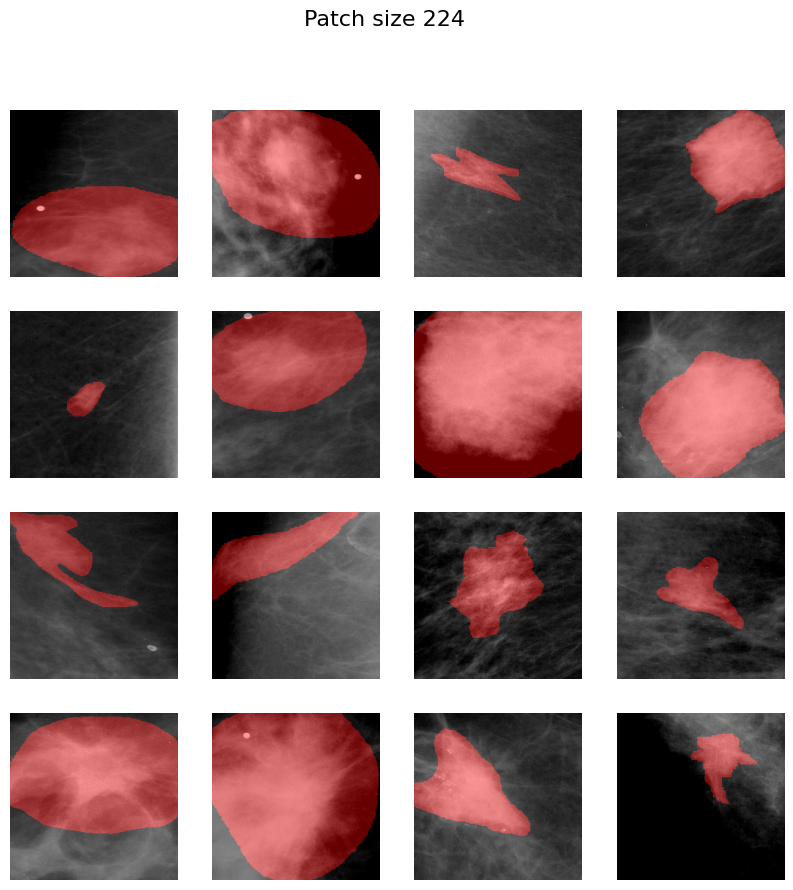

In [18]:
patch_size = 224
mass_malignat = pathlib.Path(f'/tmp/eval_patches_{patch_size}/malignant_mass/')

images = list(mass_malignat.glob('*img.png'))

#sample 16 images
nrow = 4
ncol = 4
num_images = nrow * ncol

images = np.random.choice(images, num_images)
masks = [str(img).replace('_img.png', '_mask.png') for img in images]
print("Num images: ", len(images), len(masks))

fig, ax = plt.subplots(nrows=nrow, ncols=ncol, figsize=(10, 10))
ax = ax.ravel()




for i in range(num_images):
    img = np.array(Image.open(images[i]))
    assert img.shape[0] == img.shape[1] and img.shape[0] == patch_size, f"{img.shape}"
    mask = np.array(Image.open(masks[i]))
    show_mask_image(img, mask, ax[i])

# set figure title
fig.suptitle(f"Patch size {patch_size}", fontsize=16)



Num images:  16 16


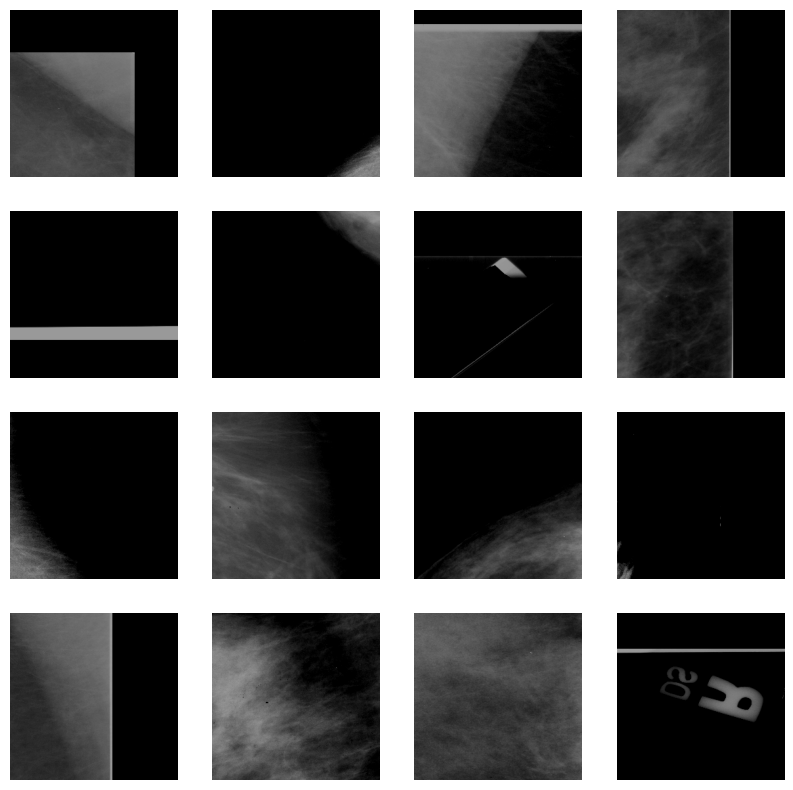

In [22]:
patch_size = 256
background = pathlib.Path(f'/tmp/eval_patches_{patch_size}/background/')

images = list(background.glob('*img.png'))

#sample 16 images
nrow = 4
ncol = 4
num_images = nrow * ncol

images = np.random.choice(images, num_images)
masks = [str(img).replace('_img.png', '_mask.png') for img in images]
print("Num images: ", len(images), len(masks))

fig, ax = plt.subplots(nrows=nrow, ncols=ncol, figsize=(10, 10))
ax = ax.ravel()



for i in range(num_images):
    img = np.array(Image.open(images[i]))
    mask = np.array(Image.open(masks[i]))
    show_mask_image(img, mask, ax[i])


# Hard negatives

In [35]:



def extract_hard_negatives_from_anot(annotation,test_images, out_dir, ddsm_root_dir,  neg_cutoff=0.2, nb_bkg=2, 
                                    patch_size=256):
    ddsm_root_dir = pathlib.Path(ddsm_root_dir)
    
    image_id = annotation['image_id']
    
    if image_id not in test_images:
        return

    
    image_path = ddsm_root_dir / image_id
    img = np.array(Image.open(str(image_path)))
    
    mask_id = annotation['mask_id']
    roi_mask_path = ddsm_root_dir / mask_id
    roi_mask = np.array(Image.open(str(roi_mask_path)))
    
    
    points = np.array(annotation['outline']).T
    
    xmin, ymin = points.min(axis=0)
    xmax, ymax = points.max(axis=0)
    xmin = max(xmin, 0)
    ymin = max(ymin, 0)
    xmax = min(xmax, img.shape[1]-1)
    ymax = min(ymax, img.shape[0]-1)
    
    width = xmax - xmin
    height = ymax - ymin
    bounding_box = (xmin, ymin, width, height)
    
    sample_hard_negatives(img, roi_mask, out_dir, mask_id, bounding_box, patch_size=patch_size,
                neg_cutoff=neg_cutoff,
                nb_bkg=nb_bkg, 
                verbose=False)


In [43]:
!rm /tmp/eval_patches_hardneg_* -rf
root_ddsm = pathlib.Path('/home/alalbiol/Data/mamo/DDSM_png_1152x896')

test_images = pd.read_csv(split_csv)
test_images = test_images.ddsm_image.values
print("num test images: ", len(test_images))


patch_size = 256

for patch_size in [512, 256, 224]:
    print(f"Extractig patches of size {patch_size}")
    out_dir = pathlib.Path(f'/tmp/eval_patches_hardneg_{patch_size}')

    out_dir.mkdir(exist_ok=True)


    for k in tqdm(range(len(annotations))):
        extract_hard_negatives_from_anot(annotations.iloc[k],test_images, out_dir, 
                                        ddsm_root_dir, patch_size=patch_size, neg_cutoff=0.2, nb_bkg=2)
        

num test images:  612
Extractig patches of size 256


100%|██████████| 4664/4664 [00:48<00:00, 96.77it/s] 


Extractig patches of size 224


100%|██████████| 4664/4664 [00:43<00:00, 106.92it/s]


Num images:  1334
Num images:  16 16


Text(0.5, 0.98, 'Hard negatives Patch size 256')

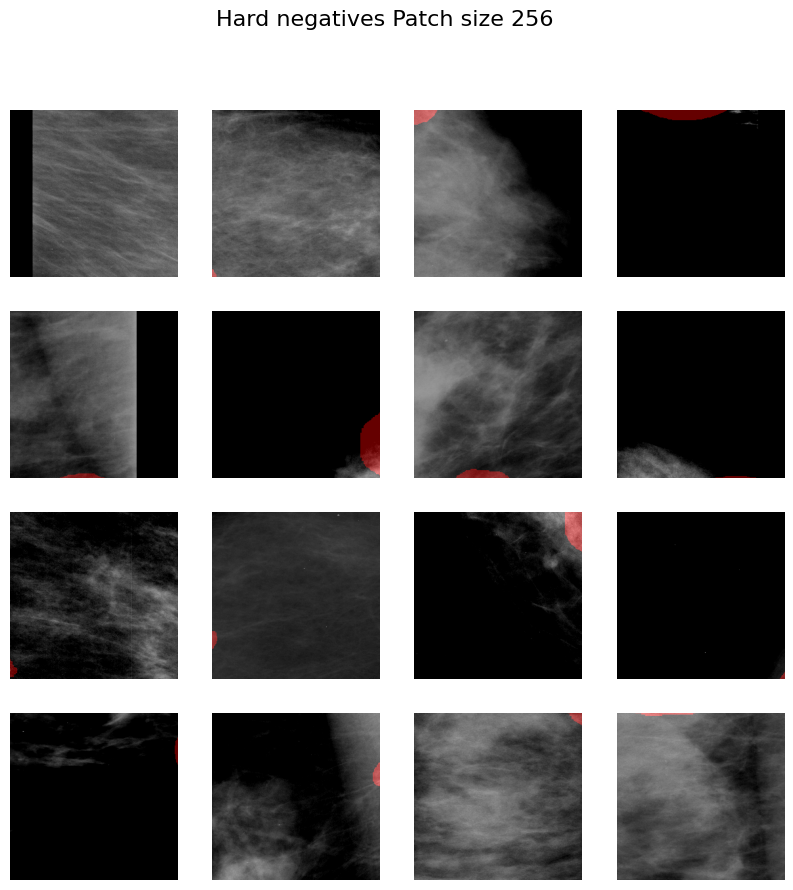

In [47]:
patch_size = 256
background = pathlib.Path(f'/tmp/eval_patches_hardneg_{patch_size}/background/')

images = list(background.glob('*img.png'))

print("Num images: ", len(images))

#sample 16 images
nrow = 4
ncol = 4
num_images = nrow * ncol

images = np.random.choice(images, num_images)
masks = [str(img).replace('_img.png', '_mask.png') for img in images]
print("Num images: ", len(images), len(masks))

fig, ax = plt.subplots(nrows=nrow, ncols=ncol, figsize=(10, 10))
ax = ax.ravel()



for i in range(num_images):
    img = np.array(Image.open(images[i]))
    mask = np.array(Image.open(masks[i]))
    assert img.shape[0] == img.shape[1] and img.shape[0] == patch_size, f"{img.shape}"
    show_mask_image(img, mask, ax[i])

fig.suptitle(f"Hard negatives Patch size {patch_size}", fontsize=16)


# Test patch extractor at blobs



In [ ]:

import cv2

def extract_negatives_from_blobs(image_path, out_dir, neg_cutoff=0.2, nb_bkg=50, patch_size=256):
        
    img = np.array(Image.open(str(image_path)))
    
    roi_mask = np.zeros_like(img, dtype=np.uint8) 
    
    
    
    img_id = image_path.name
    
    blob_min_area=3 
    blob_min_int=.5
    blob_max_int=.85
    blob_th_step=10
    
    roi_size = (256, 256)
    
        # Build a blob detector.
    params = cv2.SimpleBlobDetector_Params()
    params.filterByArea = True
    params.minArea = blob_min_area
    params.maxArea = roi_size[0]*roi_size[1]
    params.filterByCircularity = False
    params.filterByColor = False
    params.filterByConvexity = False
    params.filterByInertia = False
    # blob detection only works with "uint8" images.
    params.minThreshold = int(blob_min_int*255)
    params.maxThreshold = int(blob_max_int*255)
    params.thresholdStep = blob_th_step
    # import pdb; pdb.set_trace()
    ver = (cv2.__version__).split('.')
    if int(ver[0]) < 3:
        blob_detector = cv2.SimpleBlobDetector(params)
    else:
        blob_detector = cv2.SimpleBlobDetector_create(params)


    
    sample_blob_    negatives(img, roi_mask, out_dir, img_id, 
                blob_detector, patch_size=patch_size,
                neg_cutoff=neg_cutoff,
                nb_bkg=nb_bkg, 
                verbose=False)



In [54]:

!rm /tmp/eval_patches_blobneg_* -rf

ddsm_root_dir = pathlib.Path('/home/alalbiol/Data/mamo/DDSM_png_1152x896/normals')
normal_imgs = list(ddsm_root_dir.rglob('*.png'))
print("Number of normal images: ", len(normal_imgs))

for patch_size in [512, 256, 224]:
    print(f"Extractig patches of size {patch_size}")
    out_dir = pathlib.Path(f'/tmp/eval_patches_blobneg_{patch_size}')

    out_dir.mkdir(exist_ok=True)

    for image_path in tqdm(normal_imgs):
        extract_negatives_from_blobs(image_path, out_dir, neg_cutoff=0.2, nb_bkg=10, patch_size=patch_size)



Number of normal images:  2780
Extractig patches of size 512


100%|██████████| 2780/2780 [19:46<00:00,  2.34it/s]


Extractig patches of size 256


100%|██████████| 2780/2780 [08:06<00:00,  5.72it/s]


Extractig patches of size 224


100%|██████████| 2780/2780 [06:52<00:00,  6.74it/s]


Num images:  27383
Num images:  16 16


Text(0.5, 0.98, 'Negative blob  Patch size 256')

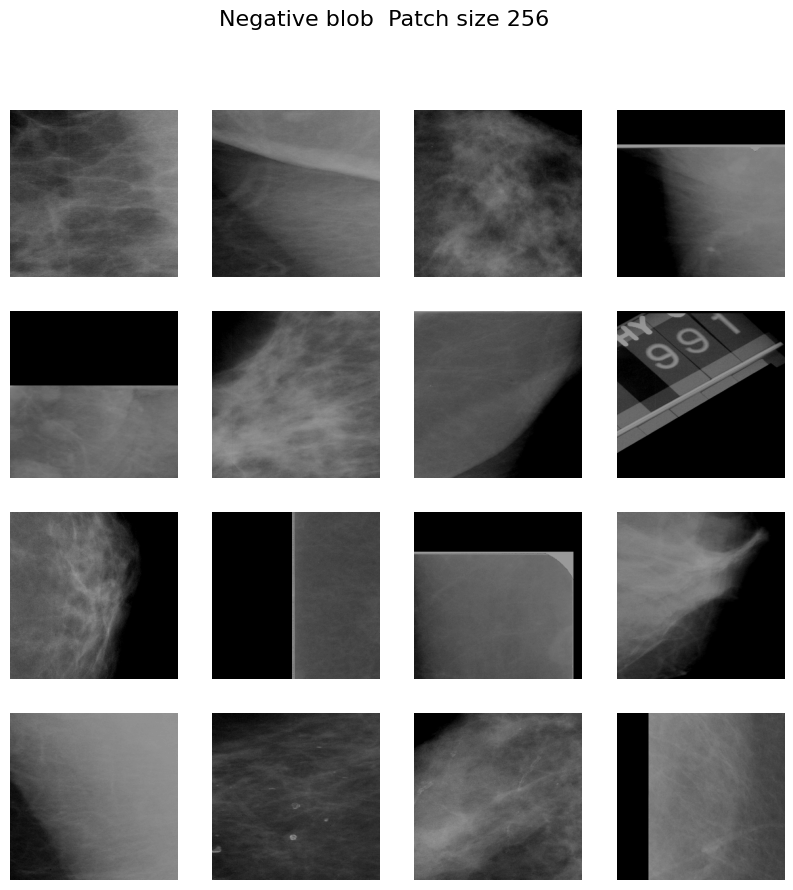

In [14]:
patch_size = 256
background = pathlib.Path(f'/tmp/eval_patches_blobneg_{patch_size}/background/')

images = list(background.glob('*img.png'))

print("Num images: ", len(images))

#sample 16 images
nrow = 4
ncol = 4
num_images = nrow * ncol

images = np.random.choice(images, num_images)
masks = [str(img).replace('_img.png', '_mask.png') for img in images]
print("Num images: ", len(images), len(masks))

fig, ax = plt.subplots(nrows=nrow, ncols=ncol, figsize=(10, 10))
ax = ax.ravel()



for i in range(num_images):
    img = np.array(Image.open(images[i]))
    mask = np.array(Image.open(masks[i]))
    assert img.shape[0] == img.shape[1] and img.shape[0] == patch_size, f"{img.shape}"
    show_mask_image(img, mask, ax[i])

fig.suptitle(f"Negative blob  Patch size {patch_size}", fontsize=16)